In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
import joblib
from imblearn.over_sampling import SMOTE
import string

In [7]:
df = pd.read_csv("attack_parsed_dataset.csv")
df

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,1.000000,0.000000,0
1,1,` :: the term ``standard model`` is itself le...,1.000000,0.000000,0
2,2,"True or false, the situation as of March 200...",1.000000,0.000000,0
3,3,"Next, maybe you could work on being less cond...",0.555556,0.444444,0
4,4,This page will need disambiguation.,1.000000,0.000000,0
...,...,...,...,...,...
115859,115859,` These sources don't exactly exude a sense ...,0.888889,0.111111,0
115860,115860,The Institute for Historical Review is a pee...,0.900000,0.100000,0
115861,115861,:The way you're trying to describe it in this...,1.000000,0.000000,0
115862,115862,== Warning == There is clearly a protection...,0.800000,0.200000,0


In [23]:
def clean_text(text):
    """Clean the text data."""
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove single characters at the start
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Substitute multiple spaces with a single space
    text = re.sub(r'^b\s+', '', text)  # Remove prefixed 'b'
    return text

def preprocess_data(df, text_column):
    """Preprocess the dataset by cleaning the text."""
    df['Text'] = df['Text'].apply(clean_text)
    return df

# Drop missing values
df.dropna(subset=['Text', 'oh_label'], inplace=True)

In [9]:
# Distribution of labels
label_counts = df['oh_label'].value_counts()
print(label_counts)


0    102274
1     13590
Name: oh_label, dtype: int64


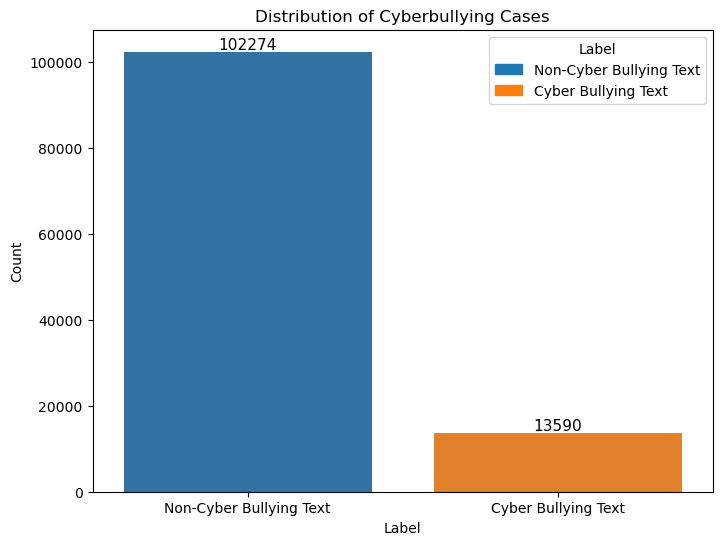

In [10]:
# Map numeric labels to descriptive text labels
label = {0: 'Non-Cyber Bullying Text', 1: 'Cyber Bullying Text'}
df['oh_label'] = df['oh_label'].replace(label)

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='oh_label', data=df)
plt.title('Distribution of Cyberbullying Cases')
plt.xlabel('Label')
plt.ylabel('Count')

# Display count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add a legend
handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette()[0], label='Non-Cyber Bullying Text'),
           plt.Rectangle((0,0),1,1, color=sns.color_palette()[1], label='Cyber Bullying Text')]
plt.legend(title='Label', handles=handles)

plt.show()


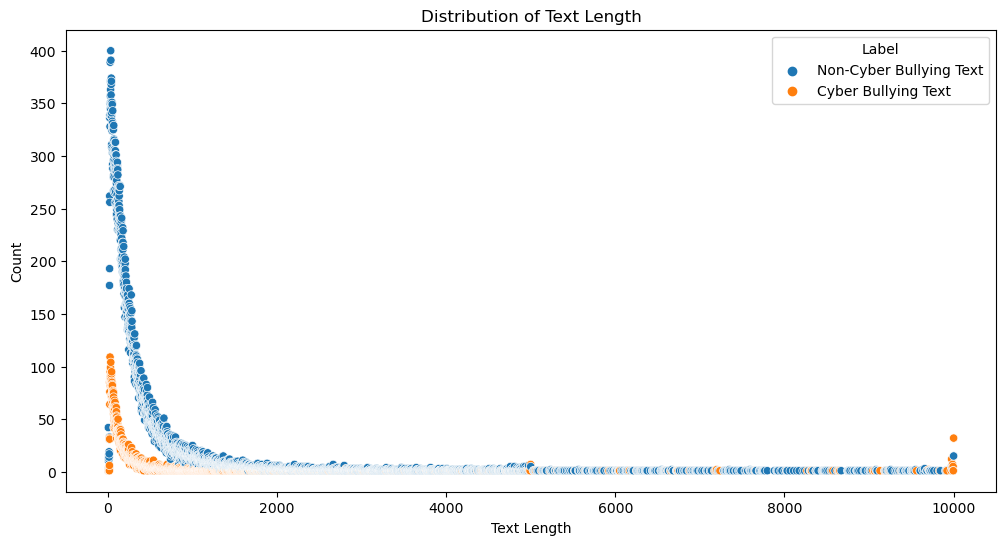

In [11]:
# Calculate the length of each text
df['text_length'] = df['Text'].apply(len)

# Map numeric labels to descriptive text labels
label = {0: 'Non-Cyber Bullying Text', 1: 'Cyber Bullying Text'}
df['oh_label'] = df['oh_label'].replace(label)

# Group by text length and label, then count occurrences
length_counts = df.groupby(['text_length', 'oh_label']).size().reset_index(name='count')

# Create the scatter plot
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(data=length_counts, x='text_length', y='count', hue='oh_label')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')

plt.legend(title='Label')

plt.show()

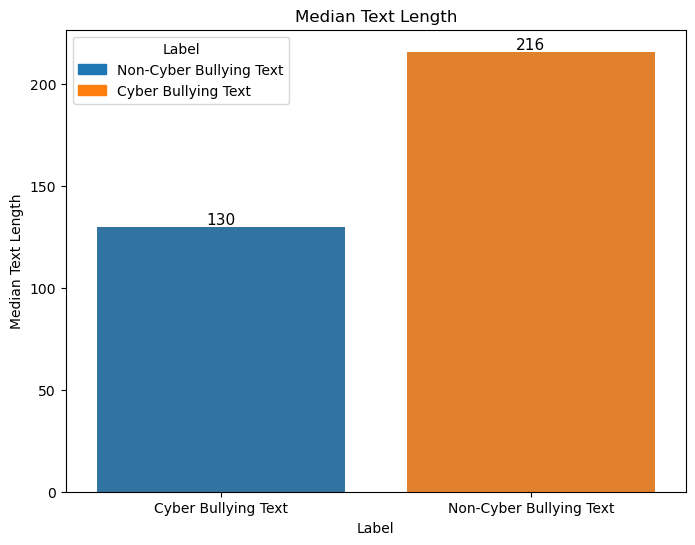

In [12]:
# Bar plot of median text length by label
## Map numeric labels to descriptive text labels
label_mapping = {0: 'Non-Cyber Bullying Text', 1: 'Cyber Bullying Text'}
df['oh_label'] = df['oh_label'].replace(label_mapping)

plt.figure(figsize=(8, 6))
median_text_length = df.groupby('oh_label')['text_length'].median().reset_index()
ax = sns.barplot(x='oh_label', y='text_length', data=median_text_length, estimator=np.median)
plt.title('Median Text Length')
plt.xlabel('Label')
plt.ylabel('Median Text Length')

# Display count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add a legend
handles = [plt.Rectangle((0,0),1,1, color=sns.color_palette()[0], label='Non-Cyber Bullying Text'),
           plt.Rectangle((0,0),1,1, color=sns.color_palette()[1], label='Cyber Bullying Text')]
plt.legend(title='Label', handles=handles)
plt.show()

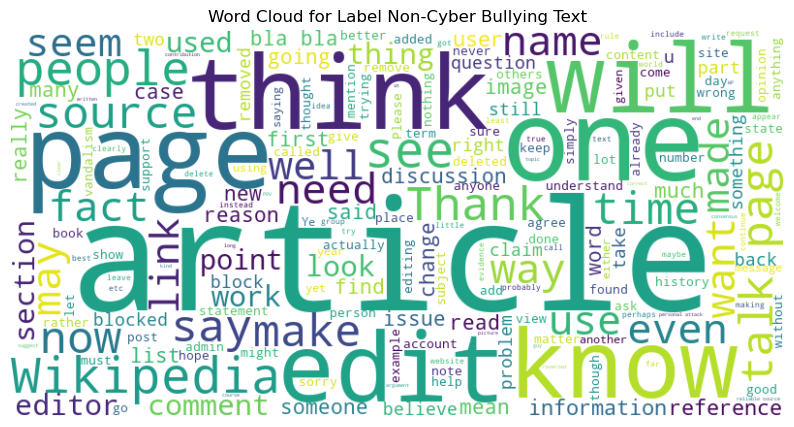

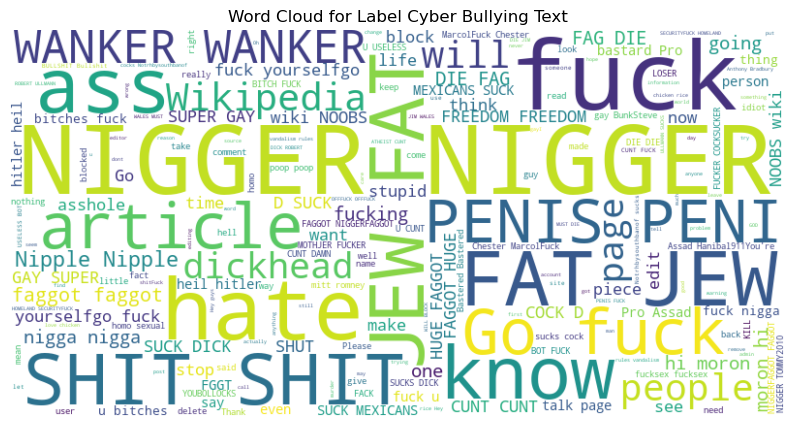

In [13]:
# Word cloud can help visualize the most common words in each label.
## Map numeric labels to descriptive text labels
label_mapping = {0: 'Non-Cyber Bullying Text', 1: 'Cyber Bullying Text'}
df['oh_label'] = df['oh_label'].replace(label_mapping)

def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each label
for label in df['oh_label'].unique():
    subset = df[df['oh_label'] == label]
    generate_wordcloud(subset['Text'], f'Word Cloud for Label {label}')

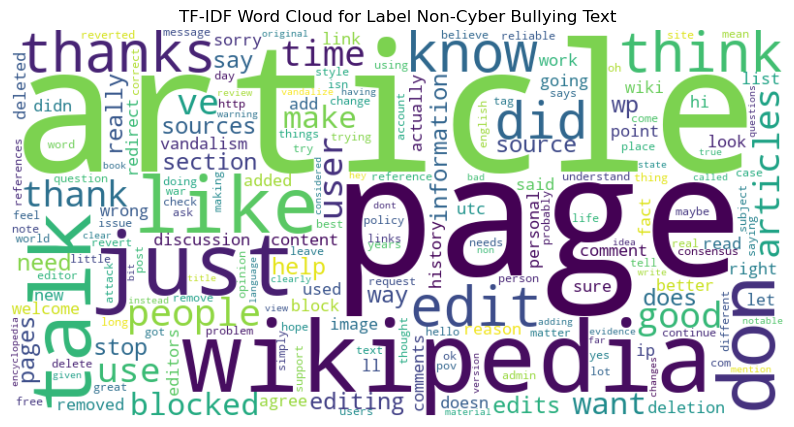

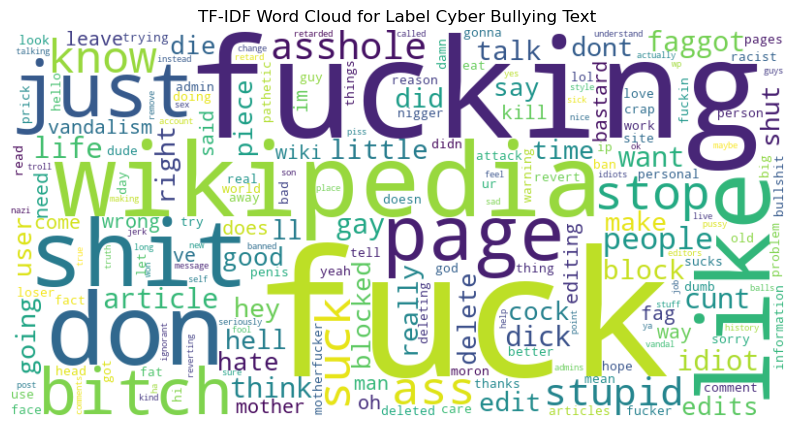

In [14]:
# Map numeric labels to descriptive text labels
label_mapping = {0: 'Non-Cyber Bullying Text', 1: 'Cyber Bullying Text'}
df['oh_label'] = df['oh_label'].replace(label_mapping)

# Function to generate a TF-IDF word cloud
def generate_tfidf_wordcloud(data, title):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(data)
    words = tfidf.get_feature_names_out()
    sums = tfidf_matrix.sum(axis=0)
    data = [(word, sums[0, idx]) for word, idx in tfidf.vocabulary_.items()]
    data = sorted(data, key=lambda x: x[1], reverse=True)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate TF-IDF word clouds for each label
for label in df['oh_label'].unique():
    subset = df[df['oh_label'] == label]
    generate_tfidf_wordcloud(subset['Text'], f'TF-IDF Word Cloud for Label {label}')


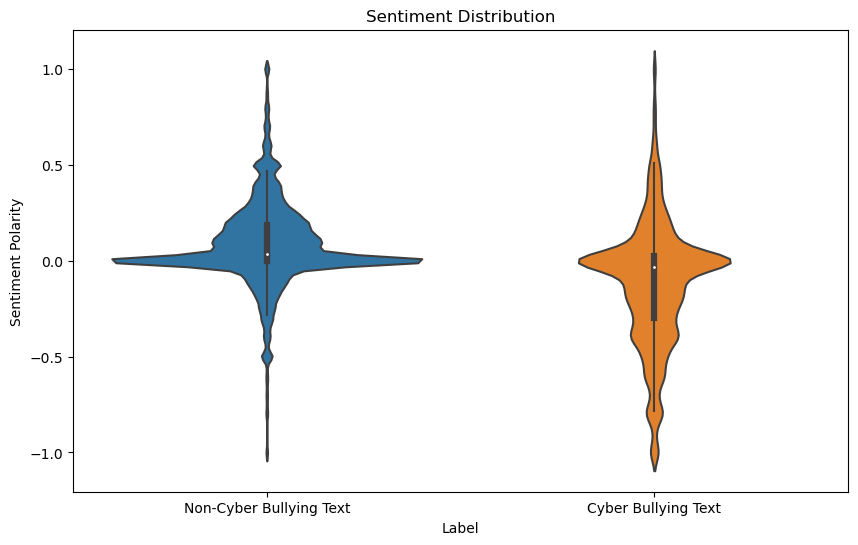

In [15]:
# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Map numeric labels to descriptive text labels
label_mapping = {0: 'Non-Cyber Bullying Text', 1: 'Cyber Bullying Text'}
df['oh_label'] = df['oh_label'].replace(label_mapping)

# Add a sentiment column to the dataframe
df['sentiment'] = df['Text'].apply(get_sentiment)

# Map numeric labels to descriptive text labels
label_mapping = {0: 'Non-Cyber Bullying Text', 1: 'Cyber Bullying Text'}
df['oh_label'] = df['oh_label'].replace(label_mapping)

# Plot the distribution of sentiment by label using a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='oh_label', y='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Label')
plt.ylabel('Sentiment Polarity')
plt.show()

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['oh_label'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the training data, transform the testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the model and the vectorizer
joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

C:\Users\summe\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9448496094592845
Classification Report:
                          precision    recall  f1-score   support

    Cyber Bullying Text       0.89      0.60      0.72      2708
Non-Cyber Bullying Text       0.95      0.99      0.97     20465

               accuracy                           0.94     23173
              macro avg       0.92      0.80      0.84     23173
           weighted avg       0.94      0.94      0.94     23173



['tfidf_vectorizer.pkl']

In [26]:
# Example preprocess_text function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load the model and the vectorizer
loaded_model = joblib.load('logistic_regression_model.pkl')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

# Sample new text data
new_texts = [
    "good job boys.................... lovely..good old times..... very nice...cool god bless your heart.....",
    "Thank you all for giving me 200 subscribers!",
    "who are you to say someone deserve to die? Man!! the american people are brain washed since forever.i hope we come around soon. Great stuff why would i want to go to war? you have to be stupid u ass. do you really think they are fighting for"
]

# Preprocess the new text data
preprocessed_texts = [preprocess_text(text) for text in new_texts]

# Transform the new text data using the loaded TF-IDF vectorizer
new_texts_tfidf = loaded_tfidf.transform(preprocessed_texts)

# Predict using the loaded model
predictions = loaded_model.predict(new_texts_tfidf)

print(predictions)

['Non-Cyber Bullying Text' 'Non-Cyber Bullying Text' 'Cyber Bullying Text']


In [41]:
# Initialize and train the Logistic Regression model with class weights
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the model and the vectorizer
joblib.dump(model, 'logistic_regression_model_balanced.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

Accuracy: 0.9297026712121866
Classification Report:
                          precision    recall  f1-score   support

    Cyber Bullying Text       0.66      0.83      0.73      2708
Non-Cyber Bullying Text       0.98      0.94      0.96     20465

               accuracy                           0.93     23173
              macro avg       0.82      0.89      0.85     23173
           weighted avg       0.94      0.93      0.93     23173



['tfidf_vectorizer.pkl']

In [42]:
# Load the model and the vectorizer
loaded_model = joblib.load('logistic_regression_model_balanced.pkl')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

# Sample new text data
new_texts = ["good job boys lovely good old times... very nice...cool god bless your heart.",
            "Thank you all for giving me 200 subscribers!",
            "who are you to say someone deserve to die? Man!! the american people are brain washed since forever.i hope we come around soon. Great stuff why would i want to go to war? you have to be stupid u ass. do you really think they are fighting for"]


# Preprocess the new text data (using the same preprocessing function)
preprocessed_texts = [preprocess_text(text) for text in new_texts]

# Transform the new text data using the loaded TF-IDF vectorizer
new_texts_tfidf = loaded_tfidf.transform(preprocessed_texts)

# Predict using the loaded model
predictions = loaded_model.predict(new_texts_tfidf)

print(predictions)

['Non-Cyber Bullying Text' 'Non-Cyber Bullying Text' 'Cyber Bullying Text']


In [37]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the model and the vectorizer
joblib.dump(model, 'logistic_regression_model_smote.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

Accuracy: 0.8920726707806499
Classification Report:
                          precision    recall  f1-score   support

    Cyber Bullying Text       0.52      0.82      0.64      2708
Non-Cyber Bullying Text       0.97      0.90      0.94     20465

               accuracy                           0.89     23173
              macro avg       0.75      0.86      0.79     23173
           weighted avg       0.92      0.89      0.90     23173



['tfidf_vectorizer.pkl']

In [39]:
# Load the model and the vectorizer
loaded_model = joblib.load('logistic_regression_model_smote.pkl')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

# Sample new text data
new_texts = ["good job boys lovely good old times... very nice...cool god bless your heart.",
            "Thank you all for giving me 200 subscribers!",
            "who are you to say someone deserve to die? Man!! the american people are brain washed since forever.i hope we come around soon. Great stuff why would i want to go to war? you have to be stupid u ass. do you really think they are fighting for"]

# Preprocess the new text data (using the same preprocessing function)
preprocessed_texts = [preprocess_text(text) for text in new_texts]

# Transform the new text data using the loaded TF-IDF vectorizer
new_texts_tfidf = loaded_tfidf.transform(preprocessed_texts)

# Predict using the loaded model
predictions = loaded_model.predict(new_texts_tfidf)

print(predictions)


['Non-Cyber Bullying Text' 'Non-Cyber Bullying Text' 'Cyber Bullying Text']


In [44]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# Initialize and fit GridSearchCV
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best estimator
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the best model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the best model and the vectorizer
joblib.dump(best_model, 'best_logistic_regression_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

C:\Users\summe\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\summe\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Parameters: {'C': 10, 'solver': 'newton-cg'}
Accuracy: 0.9354852630216199
Classification Report:
                          precision    recall  f1-score   support

    Cyber Bullying Text       0.69      0.80      0.74      2708
Non-Cyber Bullying Text       0.97      0.95      0.96     20465

               accuracy                           0.94     23173
              macro avg       0.83      0.88      0.85     23173
           weighted avg       0.94      0.94      0.94     23173



['tfidf_vectorizer.pkl']

In [49]:
# Load the model and the vectorizer
loaded_model = joblib.load('best_logistic_regression_model.pkl')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

# Sample new text data
new_texts = ["You sound like a dying animal Wow lady NO ONE CARES I I hate you like a Selena Gomez song baby Get a life Last I checked SOAP went good with showers.............. Uh oh... my dog is howling.... I'm sorry Fido... God bitch DO SOMETHING!! You are so pathetic just sitting around making these dumb videos while everyone else your age has to go to school/work hard/etc. It's all you ever do! You're a drain on fucking society. Good job tramp. Crap kid. You're good. :) You are fucking ratch. Everyone let's chip in and get a muzzle for her birthday. Poor doggie... has no idea that Nichole probably gets off to it rolling on the floor.... :/ @dawndennette What????? Lmao :D @SIERRAAA1598 Duuuude chill out. You need a friggen tranquilizer. You're like what 9 years old? Wowwww ,ass, is such a naughty word for you. Why don't you get back to grammar school before you miss nap time. And Nicoya is right you're still the one wh @bouazizforever Ouais je suis compltement d'accord! C'est comme elle pense qu'elle est tellement importante ou n'importe quoi mais vraiment elle est trop conne! Elle va rien faire avec sa vie c'est presque triste :P Dancing in public for like 2 seconds and then going somewhere else and doing the same thing is not a ,dance dare., It is just another thing Nichole337 has done to make herself look like a mongoloid. Ugh WOULD NOT BANG That's great. But the truth is that this picture is a total hoax. It wasn't even painted by a girl it was painted by a male video game artist Robert Chang. If you Google this it will have all sorts of hits including links to this guy's website. Hohhhh fuck so sorry :P Awesome! :P This video is like one big outtake You should sing at a funeral.",
            "hahah my boyfriend showed this song to me I love it Me tooo Is she having a seizure. Omg u have a corgi I am training for the Olympics and I am Russian You want some rapes... LOL",
            "wow big tune juicy tune this feels good in my brain high hopes for netsky nice amazing tune big tune i liked it! fuark still the best fucking thing on the internet do the aussies proud mate! ;) the start of something amazing.. fuark! fuark big tune tune that lift was pretty good tune If you get a virus now days you must be downloading some interesting stuff tune!! hoh what a tune!!!",
            "i like that song cool video but i hated the black spots that kept coming on the screen.lol love this song. good singing keep singing your good love this song",
            "STFU with ur god bullshit u dumbass @lostinthecrowd5827 everything apparently to the gay dudes -_- Arrraghhhh!!!! I JUST WANT THIS SHIT TO BE RELEASED ALLREADY!!! :( i imagine its hard to rap and sing with cotton mouth my mouth and throaght ge",
            "This was funking awesome the guy sucked but the girl was so funkin hot let me stroke my cock for you... I love this song and good job for acting in journey to mysteries island This is funking disturbing who really wants a little befoul girl wanting botox pit on there face You guys are amazing",
            "Dislike !! Can't believe it exist 4 this song.",
            "I luv u guys ur so awesome! ur version of our song is the only version i like. Could u do more plzzzzzzz me and bff Kels just luv ur singin. natalie from dallas",
            "LOLOLOLOL she's so different LOLOLOLOL"]


# Preprocess the new text data (using the same preprocessing function)
preprocessed_texts = [preprocess_text(text) for text in new_texts]

# Transform the new text data using the loaded TF-IDF vectorizer
new_texts_tfidf = loaded_tfidf.transform(preprocessed_texts)

# Predict using the loaded model
predictions = loaded_model.predict(new_texts_tfidf)

print(predictions)

['Cyber Bullying Text' 'Non-Cyber Bullying Text' 'Non-Cyber Bullying Text'
 'Non-Cyber Bullying Text' 'Cyber Bullying Text' 'Cyber Bullying Text'
 'Non-Cyber Bullying Text' 'Non-Cyber Bullying Text'
 'Non-Cyber Bullying Text']


In [46]:
# Convert text data into TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Save the model and the vectorizer
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

Accuracy: 0.9403616277564407
Classification Report:
                          precision    recall  f1-score   support

    Cyber Bullying Text       0.90      0.55      0.68      2708
Non-Cyber Bullying Text       0.94      0.99      0.97     20465

               accuracy                           0.94     23173
              macro avg       0.92      0.77      0.82     23173
           weighted avg       0.94      0.94      0.93     23173



['tfidf_vectorizer.pkl']

In [47]:
# Load the model and the vectorizer
loaded_rf_model = joblib.load('random_forest_model.pkl')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

# Sample new text data
new_texts = ["You sound like a dying animal Wow lady NO ONE CARES I I hate you like a Selena Gomez song baby Get a life Last I checked SOAP went good with showers.............. Uh oh... my dog is howling.... I'm sorry Fido... God bitch DO SOMETHING!! You are so pathetic just sitting around making these dumb videos while everyone else your age has to go to school/work hard/etc. It's all you ever do! You're a drain on fucking society. Good job tramp. Crap kid. You're good. :) You are fucking ratch. Everyone let's chip in and get a muzzle for her birthday. Poor doggie... has no idea that Nichole probably gets off to it rolling on the floor.... :/ @dawndennette What????? Lmao :D @SIERRAAA1598 Duuuude chill out. You need a friggen tranquilizer. You're like what 9 years old? Wowwww ,ass, is such a naughty word for you. Why don't you get back to grammar school before you miss nap time. And Nicoya is right you're still the one wh @bouazizforever Ouais je suis compltement d'accord! C'est comme elle pense qu'elle est tellement importante ou n'importe quoi mais vraiment elle est trop conne! Elle va rien faire avec sa vie c'est presque triste :P Dancing in public for like 2 seconds and then going somewhere else and doing the same thing is not a ,dance dare., It is just another thing Nichole337 has done to make herself look like a mongoloid. Ugh WOULD NOT BANG That's great. But the truth is that this picture is a total hoax. It wasn't even painted by a girl it was painted by a male video game artist Robert Chang. If you Google this it will have all sorts of hits including links to this guy's website. Hohhhh fuck so sorry :P Awesome! :P This video is like one big outtake You should sing at a funeral.",
            "hahah my boyfriend showed this song to me I love it Me tooo Is she having a seizure. Omg u have a corgi I am training for the Olympics and I am Russian You want some rapes... LOL",
            "wow big tune juicy tune this feels good in my brain high hopes for netsky nice amazing tune big tune i liked it! fuark still the best fucking thing on the internet do the aussies proud mate! ;) the start of something amazing.. fuark! fuark big tune tune that lift was pretty good tune If you get a virus now days you must be downloading some interesting stuff tune!! hoh what a tune!!!",
            "i like that song cool video but i hated the black spots that kept coming on the screen.lol love this song. good singing keep singing your good love this song",
            "STFU with ur god bullshit u dumbass @lostinthecrowd5827 everything apparently to the gay dudes -_- Arrraghhhh!!!! I JUST WANT THIS SHIT TO BE RELEASED ALLREADY!!! :( i imagine its hard to rap and sing with cotton mouth my mouth and throaght ge",
            "This was funking awesome the guy sucked but the girl was so funkin hot let me stroke my cock for you... I love this song and good job for acting in journey to mysteries island This is funking disturbing who really wants a little befoul girl wanting botox pit on there face You guys are amazing",
            "Dislike !! Can't believe it exist 4 this song.",
            "I luv u guys ur so awesome !!!!! ur version of our song is the only version i like!!!Could u do more plzzzzzzz me and bff Kels just luv ur singin!!!!!natalie from dallas",
            "LOLOLOLOL she's so different LOLOLOLOL"]

# Preprocess the new text data (using the same preprocessing function)
preprocessed_texts = [preprocess_text(text) for text in new_texts]

# Transform the new text data using the loaded TF-IDF vectorizer
new_texts_tfidf = loaded_tfidf.transform(preprocessed_texts)

# Predict using the loaded model
predictions = loaded_rf_model.predict(new_texts_tfidf)

print(predictions)

['Cyber Bullying Text' 'Non-Cyber Bullying Text' 'Non-Cyber Bullying Text'
 'Non-Cyber Bullying Text' 'Cyber Bullying Text' 'Cyber Bullying Text'
 'Non-Cyber Bullying Text' 'Non-Cyber Bullying Text'
 'Non-Cyber Bullying Text']
